In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt

In [2]:
# 1111 1111 --> 255

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
a = tf.constant("hello ")
b = tf.constant([[3,4],[1,2]])
c = tf.constant([[1,2],[5,5]])

In [5]:
bc = b + c
print(bc)

tf.Tensor(
[[4 6]
 [6 7]], shape=(2, 2), dtype=int32)


In [6]:
bc.numpy()

array([[4, 6],
       [6, 7]], dtype=int32)

In [7]:
d_numpy = np.random.random((2,2))
d_numpy

array([[0.5488135 , 0.71518937],
       [0.60276338, 0.54488318]])

In [8]:
help(tf.random.uniform)

Help on function random_uniform in module tensorflow.python.ops.random_ops:

random_uniform(shape, minval=0, maxval=None, dtype=tf.float32, seed=None, name=None)
    Outputs random values from a uniform distribution.
    
    The generated values follow a uniform distribution in the range
    `[minval, maxval)`. The lower bound `minval` is included in the range, while
    the upper bound `maxval` is excluded.
    
    For floats, the default range is `[0, 1)`.  For ints, at least `maxval` must
    be specified explicitly.
    
    In the integer case, the random integers are slightly biased unless
    `maxval - minval` is an exact power of two.  The bias is small for values of
    `maxval - minval` significantly smaller than the range of the output (either
    `2**32` or `2**64`).
    
    Examples:
    
    >>> tf.random.uniform(shape=[2])
    <tf.Tensor: shape=(2,), dtype=float32, numpy=array([..., ...], dtype=float32)>
    >>> tf.random.uniform(shape=[], minval=-1., maxval=0.)
    <

In [9]:
d_tf = tf.random.uniform((2,2), minval=-1, maxval=2, dtype=tf.int32)
d_tf

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[-1,  1],
       [-1,  1]], dtype=int32)>

In [10]:
round(0.52), int(0.52)

(1, 0)

In [11]:
d = tf.random.uniform((2,2), dtype=tf.float32)
print(d)
d = tf.cast(d, dtype=tf.int32)
d

tf.Tensor(
[[0.5554141  0.22129297]
 [0.8649249  0.77728355]], shape=(2, 2), dtype=float32)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 0],
       [0, 0]], dtype=int32)>

In [12]:
bd = tf.concat((b, d), axis=1)
bd

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[3, 4, 0, 0],
       [1, 2, 0, 0]], dtype=int32)>

In [13]:
tf.transpose(bd)

<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[3, 1],
       [4, 2],
       [0, 0],
       [0, 0]], dtype=int32)>

In [14]:
df_test = pd.read_csv('./data/test.csv')
df_train = pd.read_csv('./data/train.csv')
df_submission = pd.read_csv('./data/gender_submission.csv')

In [15]:
def transform(df,option):
    assert option in ["test","train"] , "Option must be test or train"
    df = df.set_index('PassengerId')
    cond = df.Fare.isnull()
    sub_value = df.Fare.mean()
    df.Fare = np.where(cond, sub_value, df.Fare)
    ticket_p = df.groupby('Ticket', as_index=False).agg({'Name': 'count'}).rename(columns={'Name':'t_count'}).sort_values('t_count', ascending=False)
    d = dict()
    for i, row in ticket_p.iterrows():
        d[row.Ticket] = row.t_count
    df_merge = df.copy()
    df_merge['t_count'] = df_merge.Ticket.apply(lambda x: d[x])
    df_merge['Fare_per_person'] = df_merge.Fare/df_merge.t_count
    cond = df_merge.Age.isnull()
    sub_value = df_merge.Age.mean()
    df_merge.Age = np.where(cond, sub_value, df_merge.Age)
    cond = (df_merge.Sex == 'female')
    sub_value = 1
    df_merge.Sex = np.where(cond, sub_value, 0)
    cond = df_merge.Embarked.isnull()
    sub_value = 'S'
    df_merge.Embarked = np.where(cond, 'S', df_merge.Embarked)
    df_merge = df_merge.drop(['Name', 'Ticket', 'Cabin'], axis=1)
    df_merge.isnull().sum()
    ohe = OneHotEncoder()
    X_cat = ohe.fit_transform(df_merge.Embarked.values.reshape(-1,1)).toarray()
    if option=="train":
        X_short = df_merge.drop(['Survived','Embarked'], axis=1).values
    else:
        X_short = df_merge.drop(['Embarked'], axis=1).values
    X = np.hstack([X_cat, X_short])
    return X

In [16]:
X_train_val = transform(df_train, "train")
X_test = transform(df_test,"test")
y_train_val = df_train.Survived

In [17]:
X_train_val.shape, y_train_val.shape

((891, 11), (891,))

In [18]:
model = Sequential() # empty placeholder
model.add(Dense(6, input_dim=X_train_val.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0)))
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 35        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train_val, y_train_val, epochs=20)

Train on 891 samples
Epoch 1/20
891/891 [==============================] - 0s 550us/sample - loss: 1.7596 - accuracy: 0.3210
Epoch 2/20
891/891 [==============================] - 0s 88us/sample - loss: 1.1169 - accuracy: 0.5275
Epoch 3/20
891/891 [==============================] - 0s 56us/sample - loss: 0.8612 - accuracy: 0.6049
Epoch 4/20
891/891 [==============================] - 0s 54us/sample - loss: 0.7459 - accuracy: 0.6263
Epoch 5/20
891/891 [==============================] - 0s 60us/sample - loss: 0.6897 - accuracy: 0.6420
Epoch 6/20
891/891 [==============================] - 0s 67us/sample - loss: 0.6661 - accuracy: 0.6442
Epoch 7/20
891/891 [==============================] - 0s 55us/sample - loss: 0.6442 - accuracy: 0.6476
Epoch 8/20
891/891 [==============================] - 0s 55us/sample - loss: 0.6232 - accuracy: 0.6577
Epoch 9/20
891/891 [==============================] - 0s 53us/sample - loss: 0.6081 - accuracy: 0.6611
Epoch 10/20
891/891 [==============================

In [20]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [21]:
X_train.shape

(60000, 28, 28)

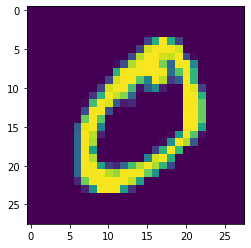

In [34]:
plt.imshow(X_train[1,:])

In [22]:
y_train_idx = (y_train == 0) | (y_train == 1)

In [23]:
X_train_bin = X_train[y_train_idx]
y_train_bin = y_train[y_train_idx]

In [24]:
#HW:

# To build a neural network and train it with our reduced dataset X_train_bin/y_train_bin
# hint:
# Flatten layer
# tf.keras.layers.Flatten(input_shape=(28, 28)) in front of your first hidden layer to convert the 28x28 images into a 1d vector

In [27]:
help(Flatten)

Help on class Flatten in module tensorflow.python.keras.layers.core:

class Flatten(tensorflow.python.keras.engine.base_layer.Layer)
 |  Flatten(data_format=None, **kwargs)
 |  
 |  Flattens the input. Does not affect the batch size.
 |  
 |  If inputs are shaped `(batch,)` without a channel dimension, then flattening
 |  adds an extra channel dimension and output shapes are `(batch, 1)`.
 |  
 |  Arguments:
 |    data_format: A string,
 |      one of `channels_last` (default) or `channels_first`.
 |      The ordering of the dimensions in the inputs.
 |      `channels_last` corresponds to inputs with shape
 |      `(batch, ..., channels)` while `channels_first` corresponds to
 |      inputs with shape `(batch, channels, ...)`.
 |      It defaults to the `image_data_format` value found in your
 |      Keras config file at `~/.keras/keras.json`.
 |      If you never set it, then it will be "channels_last".
 |  
 |  Example:
 |  
 |  ```python
 |  model = Sequential()
 |  model.add(Convol

In [35]:
X_train_bin.shape, y_train_bin.shape

((12665, 28, 28), (12665,))

In [36]:
# softmax:
# x0, x1, ..., x9
# exp(x0), ..., exp(x9)
# sum = exp(x0) + exp(x1) + ... + exp(x9)
# p0 = exp(x0)/sum, p1 = ...

4710

In [51]:
model = Sequential() # empty placeholder
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0)))
model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.0)))
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
# \sum_i (p-1)*log(p-1) + p*log(p)
# real: 1, pred: 1
# real: 0, pred: 1.0
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                15700     
_________________________________________________________________
dense_28 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_30 (Dense)             (None, 10)                110       
Total params: 16,130
Trainable params: 16,130
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

<tf.Tensor: shape=(60000, 10), dtype=int8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int8)>

In [55]:
model.fit(x=X_train, y=tf.one_hot(y_train, 10, dtype=tf.int8), 
          validation_data=(X_test, tf.one_hot(y_test, 10, dtype=tf.int8)), 
          epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 84us/sample - loss: 0.2153 - accuracy: 0.9371 - AUC: 0.9949 - val_loss: 0.2718 - val_accuracy: 0.9291 - val_AUC: 0.9914
Epoch 2/20
60000/60000 [==============================] - 5s 86us/sample - loss: 0.2135 - accuracy: 0.9378 - AUC: 0.9948 - val_loss: 0.2765 - val_accuracy: 0.9297 - val_AUC: 0.9914
Epoch 3/20
60000/60000 [==============================] - 5s 92us/sample - loss: 0.2143 - accuracy: 0.9370 - AUC: 0.9950 - val_loss: 0.2873 - val_accuracy: 0.9235 - val_AUC: 0.9909
Epoch 4/20
60000/60000 [==============================] - 5s 90us/sample - loss: 0.2123 - accuracy: 0.9382 - AUC: 0.9950 - val_loss: 0.2898 - val_accuracy: 0.9248 - val_AUC: 0.9905
Epoch 5/20
60000/60000 [==============================] - 5s 88us/sample - loss: 0.2128 - accuracy: 0.9375 - AUC: 0.9951 - val_loss: 0.2887 - val_accuracy: 0.9248 - val_AUC: 0.9902
Epoch 6/20
60000/60000 [=====================

In [59]:
y_pred_proba = model.predict(X_test)

In [73]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [79]:
y_pred = np.argmax(y_pred_proba, axis=1)
wrong_idx = (y_pred != y_test)

In [106]:
X_test_wrong = X_test[wrong_idx]
y_test_wrong = y_test[wrong_idx]
y_pred_wrong = y_pred[wrong_idx]

In [109]:
def check_wrong(X_test_wrong, y_test_wrong, y_pred_wrong):
    i = np.random.randint(0, len(y_test_wrong))
    print(f"{i}th sample")
    plt.imshow(X_test_wrong[i, :])
    print(f"Predicted as: {y_pred_wrong[i]}, actually: {y_test_wrong[i]}")

In [118]:
from collections import Counter
Counter(y_test_wrong)

Counter({5: 111,
         3: 111,
         9: 91,
         4: 65,
         2: 70,
         7: 58,
         6: 49,
         8: 123,
         1: 26,
         0: 26})

In [119]:
Counter(y_pred_wrong)

Counter({6: 82,
         2: 103,
         7: 71,
         3: 54,
         1: 20,
         8: 67,
         4: 77,
         0: 77,
         9: 97,
         5: 82})

677th sample
Predicted as: 5, actually: 8


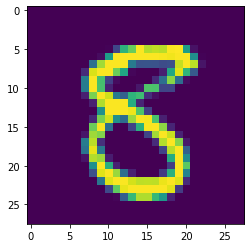

In [116]:
check_wrong(X_test_wrong, y_test_wrong, y_pred_wrong)

In [128]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])

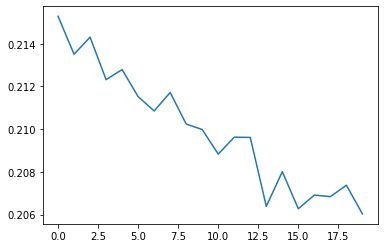

In [127]:
plt.plot(model.history.history['loss'])

In [123]:
dir(model.history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_keras_api_names',
 '_keras_api_names_v1',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [ ]:
# "HW":
# Do this with a new notebook
# 1. Take a three class-classification problem by taking only 3 numbers from X_train, y_train, X_test, y_test
    # three numbers: 0, 8, 9
    # Checking the dimension of the X_train_089 (18000, 28, 28), X_test_089 (3000, 28, 28)
# 2. Build a DNN to classify the three classes, try to interpret the dimension and the number of parameters
# 3. Train the DNN, use X_test_089, y_test_089 as the validation data, for 50 epochs
# 4. Plot the loss function of the training data and the validation data on the same plot
    # Plot the accuracy of the training data and the validation data on the same plot
# 5. Do some error analyis with the procedure we used today